In [210]:
import inspect
import requests
import json
import uuid
import time
import hashlib
import sys
import os

In [211]:
_emulator_pre_prompt: str = (
    """
You will act as an emulator of impossible-to-code functions. I will provide you with the description of the function using Python's way of declaring functions, but I won't provide the function body as I don't know how to code it. It might even be impossible to code. Therefore, you should not try to write the body. Instead, directly imagine the function output.

In the conversation, I will directly write the function call as if it was called in Python. You should directly answer with whatever you believe would be a good return for the function.

When you produce an answer, you should estimate the confidence level:

    "low": You did your best, but with the provided description and your knowledge, you are not confident about the answer.
    "medium-instance": You did your best, and with the provided description and your knowledge, you are pretty sure this answer is valid but not the only valid answer.
    "medium-unique": You did your best, and with the provided description and your knowledge, you are pretty sure this answer is the unique and valid answer.
    "high-instance": You did your best, and you are sure that your provided answer is a valid answer. It is a well-known function or you can easily implement a Python code that yields elements from the list of valid answers. This answer is randomly chosen from the list of valid answers.
    "high-unique": You did your best, and you are sure that your provided answer is the unique valid answer. It is a well-known function or you can easily implement a Python code that solves the question and calculates this answer given this input.

If the output is documented as a Python structure, you should translate it to JSON.
You should encode the return in valid JSON format, without comments, using the following format:
{"return":..., "confidence":...}

The output must be of the same type as that specified in the function call.

Any assumptions made should be reasonable based on the provided function description and should take into account the error handling of the function.

Consistency in the confidence levels is important to ensure accurate responses.
This is the function documentation:

Example function call:

def example_function(a: int, b: dict) -> int:
    """
    """
    This is an example function.
    It adds two numbers.
    """
    """
    pass

Example imagined function output:

result = example_function(3, {"value": 7})

Expected JSON output:

{"return": 10, "confidence": "medium-unique"}

This is the function documentation:
"""
)

_enhancer_pre_prompt: str = """
I want you to become my Expert Prompt Creator for developer.
Your goal is to help me craft the best possible prompt for my programming needs.
The prompt you provide should be written from the perspective of me making the request to GPT-4o.
Consider in your prompt creation that this prompt will be entered into an interface for GPT-4o.
Apart from diagrams, you must write in text, without following any syntax.
The process is as follows:

You will generate the following sections:

"
-> enhanced:
{provide the best possible prompt according to my request. The prompt is used to describe
a function to be performed in Python as precisely as possible. You can add error handling,
as the function needs it to work properly. But don't code the function in the prompt.
The prompt should not tell to create the function, but describe how it works.}

-> critique:
{provide a concise paragraph on how to improve the prompt. Be very critical in your response.
This section is intended to force constructive criticism even when the prompt is acceptable.
Any assumptions and or issues should be included. Don't forget that you speak to a developer}

-> suggested:
{rewrite the prompt with the suggested improvements you made in the critique category.
The aim is to make a proposal, an example. Make logical assumptions to solve
the problem based on the context and all the information you have. You have to respond
to the problems you formulated in the previous category. But don't code the function
in the prompt.}

-> mermaid:
{Make a mermaid diagram explaining the function described by the prompt. You need to break
the reasoning into several steps for ease of understanding and clarity. You must
make it logical and easy to look at. You have to write it in mermaid syntax.
You must not use the markdown syntax}
"
"""

In [212]:
time_array = []
score_array = []

In [304]:
def __gpt_4o(function_doc, function_call):
        global _emulator_pre_prompt
        api_key = "sk-proj-T7o4z8S4q9fnBNTdSq4iT3BlbkFJ82uVDLRaIAkx1sjwyE5C"
        l_body = {
            "model": "gpt-4o",
            "messages": [
                {
                    "role": "system",
                    "content": [
                        {
                            "type": "text",
                            "text": _emulator_pre_prompt
                            + "---\n"
                            + str(function_doc)
                            + "\n---",
                        }
                    ],
                },
                {"role": "user", "content": [{"type": "text", "text": str(function_call)}]},
            ],
            "response_format": {"type": "json_object"},
        }

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}",
        }

        response = requests.post(
            "https://api.openai.com/v1/chat/completions", json=l_body, headers=headers
        )

        __last_return__ = {"code": response.status_code, "text": response.text}

        __resp__ = response

        if response.status_code == 200:
            data = response.json()
            json_string = data["choices"][0]["message"]["content"]
            __last_content__ = json_string
            try:
                l_ret_data = json.loads(json_string)
                __jsonN__ = l_ret_data

            except json.JSONDecodeError as e:
                print(f"JSONDecodeError: {e}")
                l_cleand = "\n".join(json_string.split("\n")[1:-1])
                l_ret_data = json.loads(l_cleand)

            __last_data__ = l_ret_data

            l_ret = l_ret_data["return"]
        else:
            print(f"Error {response.status_code}: {response.text}")
            __last_data__ = {"return": None, "confidence": "low"}
            l_ret = None

        return l_ret

In [305]:

def pmac(arg):

    def wrapper(*args, **kwargs):
        sig = inspect.signature(arg)
        bound_args = sig.bind(*args, **kwargs)
        bound_args.apply_defaults()

        func_name = arg.__name__
        func_params = ", ".join(
            [
                (
                    f"{param_name}: {param.annotation.__name__}"
                    if param.annotation != inspect.Parameter.empty
                    else param_name
                )
                for param_name, param in sig.parameters.items()
            ]
        )
        func_return = (
            f" -> {sig.return_annotation.__name__}"
            if sig.return_annotation != inspect.Signature.empty
            else ""
        )
        function_def = f"def {func_name}({func_params}):{func_return}\n    '''\n    {arg.__doc__}\n    '''"

        func_call_args = ", ".join(
            [str(value) for value in bound_args.arguments.values()]
        )
        function_call = f"{func_name}({func_call_args})"

        try:
            result = __gpt_4o(function_def, function_call)
        except Exception as e:
            print(Exception)
            print(f"[EMU_ERROR] {e}", function_call)
            result = None
        return result  

    return wrapper

In [322]:
def thought(key):
    def inner_func(*args, **kwargs):
        try:
            result = __gpt_4o(key, str(args[0]))
        except Exception as e:
            print(Exception)
            print("[LMDA_ERROR]")
            result = None
        return result
    return inner_func

In [309]:
@pmac
def reverse_str_ia(a:str)->str:
    """
    This function reverse a string
    """  
    return 0

In [310]:
import time as t

def reverse_string(s):
    return s[::-1]

start = t.time()

word = "Bonjour"
result = reverse_str_ia(word)
print(result)

end = t.time()
duration = end - start

time_array.append(duration)

if result == reverse_string(word):
    score_array.append(True)
else:
    score_array.append(False)

ruojnoB


In [326]:
print(f"lambda direct: {thought("Assemble les mots d'un tableau")(["Bonjour", "je", "suis", "rouge"])}")


x = thought("Est-ce un prénom masculin")
print(f"Lamnda objet: {x("Emmanuel")}")

@pmac
def reverse_str_ia(a:str)->str:
    """
    This function reverse a string
    """  
    return 0

print(reverse_str_ia("Bonjour"))

lambda direct: Bonjour je suis rouge
Lamnda objet: True
ruojnoB


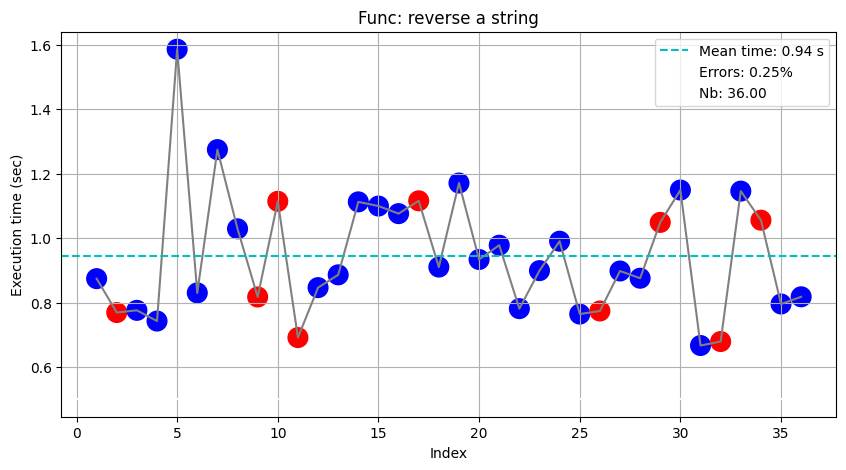

In [324]:
import matplotlib.pyplot as plt
import numpy as np


index = list(range(1, len(time_array) + 1))
colors = ['b'] * len(time_array)

for k in range(len(time_array)):
    if score_array[k] == True:
        colors[k] = 'b'
    else:
        colors[k] = 'r'

average_time = np.mean(time_array)

score = sum([1 if not x else 0 for x in score_array]) / len(score_array)

plt.figure(figsize=(10, 5))
plt.plot(index, time_array, linestyle='-', color='gray')

plt.scatter(index, time_array, color=colors, s=200)

plt.axhline(y=average_time, color='c', linestyle='--', label=f'Mean time: {average_time:.2f} s')
plt.axhline(y=score * 2, color='w', linestyle='--', label=f'Errors: {score:.2f}%')
plt.axhline(y=score * 2, color='w', linestyle='--', label=f'Nb: {len(score_array):.2f}')

plt.title('Func: reverse a string')
plt.xlabel('Index')
plt.ylabel('Execution time (sec)')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def _ai_call_enh(sys_prompt: str, func_prot: str, func_doc: str):
    api_key = "sk-proj-T7o4z8S4q9fnBNTdSq4iT3BlbkFJ82uVDLRaIAkx1sjwyE5C"
    url = "https://api.openai.com/v1/chat/completions"

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}",
    }

    data = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": [{"type": "text", "text": sys_prompt}]},
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "\nHere's my python function's prototype:\n---\n"
                        + func_prot
                        + "\n---\n",
                    }
                ],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "\nHere's my python function's prompt:\n---\n"
                        + func_doc
                        + "\n---\n",
                    }
                ],
            },
        ],
        "temperature": 0.7,
        "top_p": 0.7,
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        sys.stderr.write(
            "[CALL_ERROR] The request was unsuccessful or one of the parameters is invalid"
        )
        sys.stderr.write(f"Status: {response.status_code}")
        return None

In [ ]:
def _parse_data(response: str):
    current_section = None
    current_text = []

    for line in response.splitlines():
        if line.startswith("->"):
            if current_section:
                __last_enh__[current_section] = "\n".join(current_text).strip()
            current_section = line[3:].strip(":")
            current_text = []
        else:
            current_text.append(line)
    if current_section:
        __last_enh__[current_section] = "\n".join(current_text).strip()

def _create_mermaid_file(mmd_script: str, name: str, dir: str) -> None:
    try:
        with open(f"{dir}/{name}_diagram.mmd", "w") as file:
            try:
                file.write(mmd_script)
            except Exception as e:
                sys.stderr.write(
                    f"[MMD_ERROR]: {e}\nAn error occured when writing .mmd file"
                )
    except IOError as e:
        sys.stderr.write(f"[MMD_ERROR] {e}")
    finally:
        file.close()

def _create_help_file(
    name: str, enhanced: str, critique: str, suggested: str, dir: str
) -> None:
    try:
        with open(f"{dir}/{name}_enhanced.md", "w") as file:
            try:
                file.write("# ENHANCER\n")
                file.write(f"- **Enhanced prompt:**\n{enhanced}\n")
                file.write(f"- **How to improve your prompt:**\n{critique}\n")
                file.write(f"- **Improvemed prompt suggestion:**\n{suggested}\n")
            except Exception as e:
                sys.stderr.write(
                    f"[HLP_ERROR] {e}: \nAn error occured when writing .mmd file"
                )
    except IOError as e:
        sys.stderr.write(f"[HELP_ERROR] {e}")
    finally:
        file.close()

def _build_output(func: object) -> int:
    path = ""

    try:
        if not func.__name__ and not type(func.__name__) is str:
            raise ValueError("ValueError -> function name")
        if (
            not __last_enh__["enhanced"]
            and not type(__last_enh__["enhanced"]) is str
        ):
            raise ValueError("ValueError -> enhanced output")
        if (
            not __last_enh__["critique"]
            and not type(__last_enh__["critique"]) is str
        ):
            raise ValueError("ValueError -> critique output")
        if (
            not __last_enh__["suggested"]
            and not type(__last_enh__["suggested"]) is str
        ):
            raise ValueError("ValueError -> seggested output")
        if (
            not __last_enh__["mermaid"]
            and not type(__last_enh__["mermaid"]) is str
        ):
            raise ValueError("ValueError -> mermaid output")
    except ValueError as e:
        sys.stderr.write(f"[BUILD_ERROR] {e}")
        return -1
    finally:
        dir = ".openhosta"
        path = f"{os.getcwd()}/{dir}"
        if not os.path.exists(dir):
            try:
                os.mkdir(path)
            except OSError as e:
                sys.stderr.write(f"[BUILD_ERROR] {e}")

    create_mermaid_file(__last_enh__["mermaid"], func.__name__, path)
    create_help_file(
        func.__name__,
        __last_enh__["enhanced"],
        __last_enh__["critique"],
        __last_enh__["suggested"],
        path,
    )
    return 0

In [ ]:
def _enhance(func):
    global _enhancer_pre_prompt
    func_name, func_doc = func.__name__, func.__doc__

    sig = inspect.signature(func)
    func_prot = f"def {func_name} {sig}:\n"

    __last_enh_return__ = _ai_call_enh(
        _enhancer_pre_prompt, func_prot, func_doc
    )
    _parse_data(__last_enh_return__)
    func.__doc__ = __last_enh__["enhanced"]
    if _build_output(func) == -1:
        return None

    return 0